In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder


from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/My Drive/carclaims.csv')

#print(df.columns)
print(df['FraudFound'].value_counts())

# Encode labels: 'Yes' -> 1, 'No' -> 0
label_encoder = LabelEncoder()
#df['fraud_encoded'] = label_encoder.fit_transform(df['FraudFound'])

# Encode categorical variables
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'FraudFound':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
    else :
        df_encoded['fraud_encoded'] = label_encoder.fit_transform(df_encoded['FraudFound'])

# Compute correlation with target
correlations = df_encoded.corr(numeric_only=True)['fraud_encoded'].sort_values(ascending=False)
print(correlations)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
FraudFound
No     14497
Yes      923
Name: count, dtype: int64
fraud_encoded           1.000000
VehiclePrice            0.061541
Sex                     0.029953
PastNumberOfClaims      0.023363
Deductible              0.017348
NumberOfSuppliments     0.013264
NumberOfCars            0.009109
DriverRating            0.007266
Days:Policy-Accident    0.005529
MaritalStatus           0.000568
DayOfWeekClaimed       -0.002065
WeekOfMonthClaimed     -0.005761
RepNumber              -0.007551
WitnessPresent         -0.008057
Month                  -0.008670
MonthClaimed           -0.010247
WeekOfMonth            -0.011861
Days:Policy-Claim      -0.015400
PoliceReportFiled      -0.016007
DayOfWeek              -0.017456
Make                   -0.019187
PolicyNumber           -0.020345
AgeOfVehicle           -0.022236
AgentType              -0.022978
Year            

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define features and target
X = df_encoded.drop(columns=['FraudFound', 'fraud_encoded'])
y = df_encoded['fraud_encoded']

# Drop 'PolicyNumber','RepNumber' from the feature set
X = X.drop(columns=['PolicyNumber'])
X = X.drop(columns=['RepNumber'])

print("done")

done


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2
# ----------- RFE -----------
rfe_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=3)
rfe.fit(X, y)
# Accessing pandas DataFrame columns using boolean indexing based on rfe.support_
X_rfe = X.loc[:, rfe.support_]  # Use .loc for label-based or boolean indexing

# Apply Chi-Square
chi_selector = SelectKBest(score_func=chi2, k=3)
chi_selector.fit(X, y)
chi_columns = X.columns[chi_selector.get_support()]

# Use chi-squared selected columns for plotting
X_chi = X[chi_columns]  # Subset with only chi-squared important features

# ----------- Train/Test Split -----------
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3, random_state=42)
X_train_chi, X_test_chi, _, _ = train_test_split(X_chi, y, test_size=0.3, random_state=42)

# ----------- Train Models -----------
clf_rfe = RandomForestClassifier(random_state=42)
clf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = clf_rfe.predict(X_test_rfe)

clf_chi = RandomForestClassifier(random_state=42)
clf_chi.fit(X_train_chi, y_train)
y_pred_chi = clf_chi.predict(X_test_chi)

# ----------- Evaluation -----------
print("📊 RFE Feature Subset Performance:")
print(classification_report(y_test, y_pred_rfe))

print("\n📊 Chi-Square Feature Subset Performance:")
print(classification_report(y_test, y_pred_chi))

# Optional: show which features were selected
print("\n🧠 Top 3 RFE Features:")
print(list(X_rfe.columns))

print("\n🧠 Top 3 Chi-Square Features:")
print(list(chi_columns))


📊 RFE Feature Subset Performance:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4341
           1       0.06      0.01      0.02       285

    accuracy                           0.92      4626
   macro avg       0.50      0.50      0.49      4626
weighted avg       0.88      0.92      0.90      4626


📊 Chi-Square Feature Subset Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4341
           1       0.00      0.00      0.00       285

    accuracy                           0.94      4626
   macro avg       0.47      0.50      0.48      4626
weighted avg       0.88      0.94      0.91      4626


🧠 Top 3 RFE Features:
['Month', 'Make', 'Age']

🧠 Top 3 Chi-Square Features:
['Fault', 'VehiclePrice', 'BasePolicy']


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


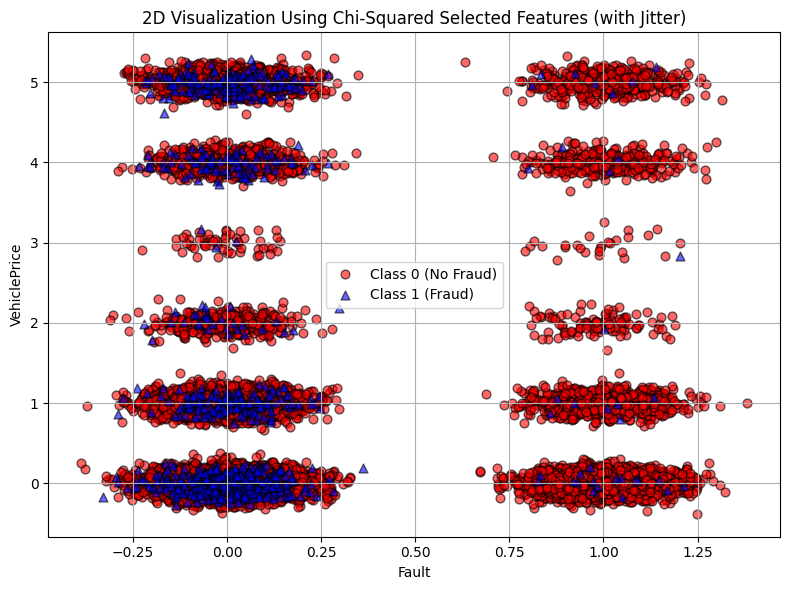

Plotted features: Index(['Fault', 'VehiclePrice'], dtype='object')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_chi = X[chi_columns]  # Subset with only chi-squared important features

# Extract the two most important chi-squared features
x_vals = X_chi[chi_columns[0]].values
y_vals = X_chi[chi_columns[1]].values

# Add small jitter if features are categorical or binary
def jitter(arr, noise=0.1):
    return arr + np.random.normal(0, noise, size=arr.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(jitter(x_vals[y == 0]), jitter(y_vals[y == 0]),
            color='red', alpha=0.6, label='Class 0 (No Fraud)', s=40, edgecolor='k', marker='o')
plt.scatter(jitter(x_vals[y == 1]), jitter(y_vals[y == 1]),
            color='blue', alpha=0.6, label='Class 1 (Fraud)', s=40, edgecolor='k', marker='^')

plt.title('2D Visualization Using Chi-Squared Selected Features (with Jitter)')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the features being used
print("Plotted features:", chi_columns[:2])



# New section

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4341
           1       0.00      0.00      0.00       285

    accuracy                           0.94      4626
   macro avg       0.47      0.50      0.48      4626
weighted avg       0.88      0.94      0.91      4626

ROC AUC Score: 0.7790023319067075


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


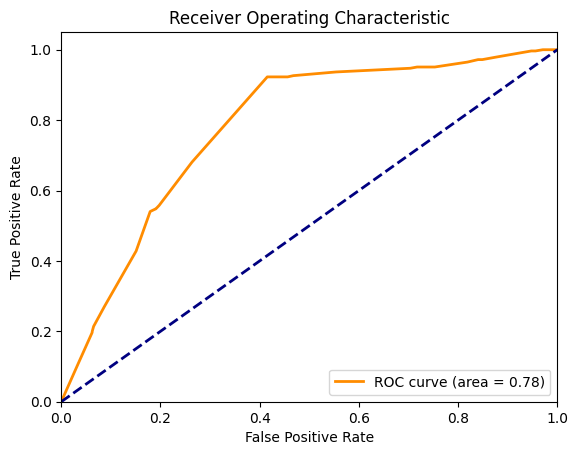

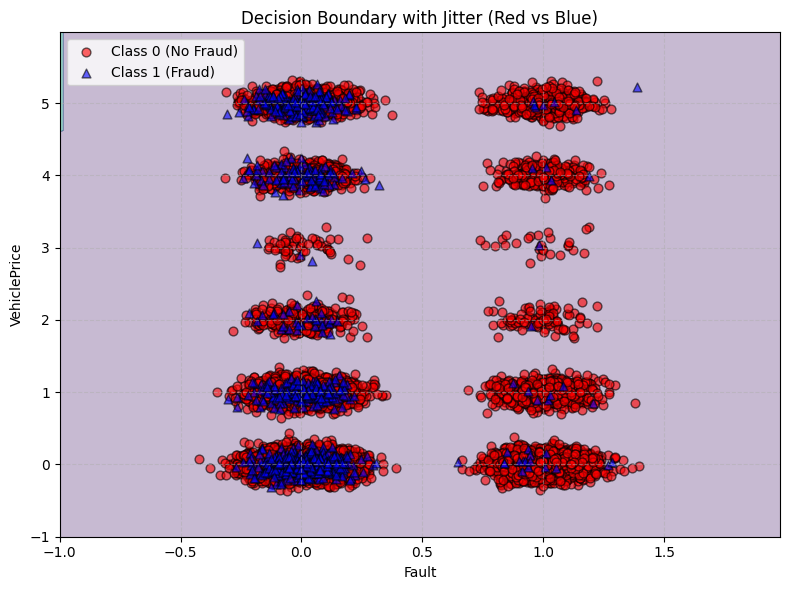

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chi, y, test_size=0.3, random_state=42)

# Initialize and train RandomForest classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict test set
y_pred = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


def jitter(arr, noise=0.1):
    return arr + np.random.normal(0, noise, size=arr.shape)

def plot_decision_boundaries(X, y, model, jitter_strength=0.1):
    plot_step = 0.02
    # Only use the features the model was trained on for plotting:
    x_min, x_max = X[chi_columns[0]].min() - 1, X[chi_columns[0]].max() + 1
    y_min, y_max = X[chi_columns[1]].min() - 1, X[chi_columns[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # Create grid_data with the correct columns
    grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=chi_columns[:2])

    # If the model was trained on more than 2 features,
    # you'll need to add the remaining features to grid_data with mean values:
    for col in chi_columns[2:]:  # If chi_columns has more than 2 features
        grid_data[col] = X[col].mean()

    Z = model.predict(grid_data)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)

    # Jittered values
    x_vals = X[chi_columns[0]].values  # Use chi_columns for x_vals and y_vals
    y_vals = X[chi_columns[1]].values

    plt.scatter(jitter(x_vals[y == 0], jitter_strength),
                jitter(y_vals[y == 0], jitter_strength),
                color='red', alpha=0.6, label='Class 0 (No Fraud)',
                s=40, edgecolor='k', marker='o')

    plt.scatter(jitter(x_vals[y == 1], jitter_strength),
                jitter(y_vals[y == 1], jitter_strength),
                color='blue', alpha=0.6, label='Class 1 (Fraud)',
                s=40, edgecolor='k', marker='^')

    plt.xlabel(chi_columns[0])
    plt.ylabel(chi_columns[1])
    plt.title("Decision Boundary with Jitter (Red vs Blue)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot decision boundary
plot_decision_boundaries(X, y, classifier)



### Random Undersampling

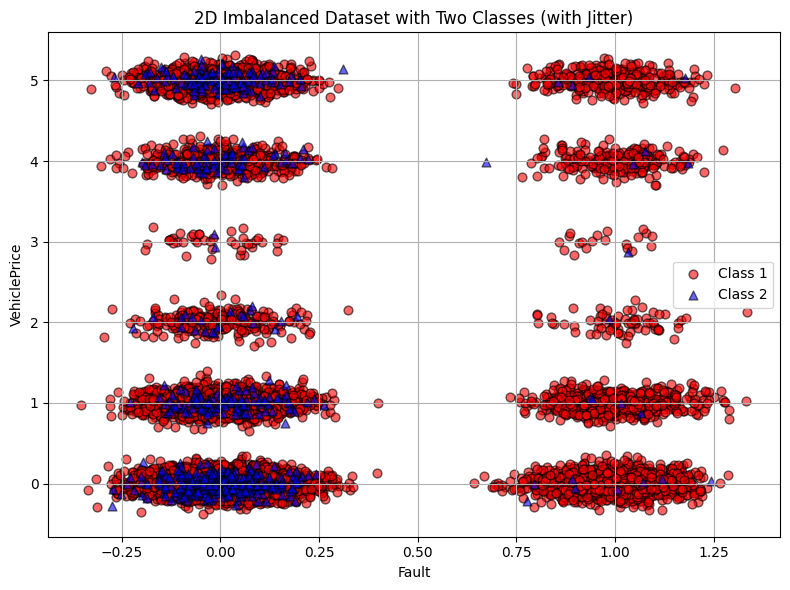

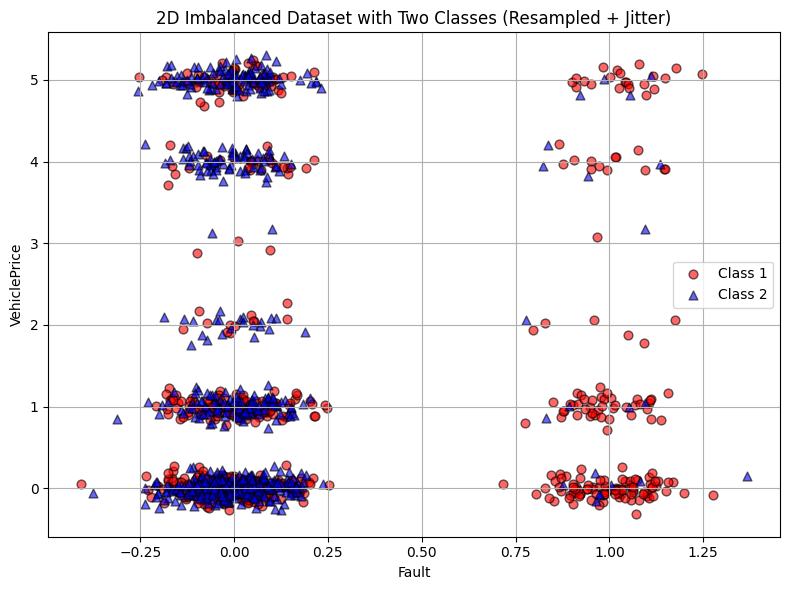

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chi, y, test_size=0.3, random_state=42)

# Applying Random Over Sampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Create a DataFrame with the resampled data using the new index
X_resampled_df = pd.DataFrame(X_resampled, index=y_resampled.index, columns=X_train.columns) # This is the fix!

X_train_class_0 = X_train[y_train == 0].values
X_train_class_1 = X_train[y_train == 1].values


def jitter(arr, noise=0.1):
    return arr + np.random.normal(0, noise, size=arr.shape)
# Apply jitter
X_train_class_0_jittered = np.column_stack((
    jitter(X_train_class_0[:, 0]),
    jitter(X_train_class_0[:, 1])
))
X_train_class_1_jittered = np.column_stack((
    jitter(X_train_class_1[:, 0]),
    jitter(X_train_class_1[:, 1])
))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_train_class_0_jittered[:, 0], X_train_class_0_jittered[:, 1],
            color='red', label='Class 1', alpha=0.6, edgecolor='k', s=40, marker='o')
plt.scatter(X_train_class_1_jittered[:, 0], X_train_class_1_jittered[:, 1],
            color='blue', label='Class 2', alpha=0.6, edgecolor='k', s=40, marker='^')
plt.title('2D Imbalanced Dataset with Two Classes (with Jitter)')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply jitter on resampled data
x0 = jitter(arr=X_resampled_df[y_resampled == 0].iloc[:, 0])
y0 = jitter(X_resampled_df[y_resampled == 0].iloc[:, 1])
x1 = jitter(X_resampled_df[y_resampled == 1].iloc[:, 0])
y1 = jitter(X_resampled_df[y_resampled == 1].iloc[:, 1])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x0, y0, color='red', label='Class 1', alpha=0.6, edgecolor='k', s=40, marker='o')
plt.scatter(x1, y1, color='blue', label='Class 2', alpha=0.6, edgecolor='k', s=40, marker='^')
plt.title('2D Imbalanced Dataset with Two Classes (Resampled + Jitter)')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
X_train.shape

(10794, 3)

In [ ]:
X_resampled.shape

(1276, 3)

In [ ]:
import pandas as pd

pd.Series(y_train).value_counts()

,count
fraud_encoded,
0,10156
1,638


In [ ]:
pd.Series(y_resampled).value_counts()

,count
fraud_encoded,
0,638
1,638


Classification Report (With Under Sampling):
              precision    recall  f1-score   support

           0       0.99      0.58      0.74      4341
           1       0.13      0.92      0.22       285

    accuracy                           0.61      4626
   macro avg       0.56      0.75      0.48      4626
weighted avg       0.94      0.61      0.70      4626

ROC AUC Score (With Under Sampling): 0.7789675755848964


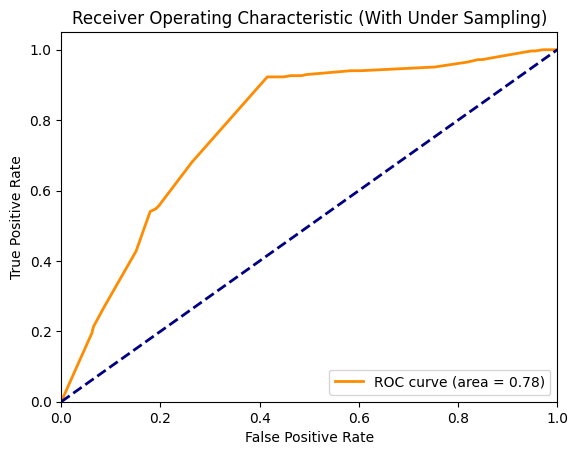

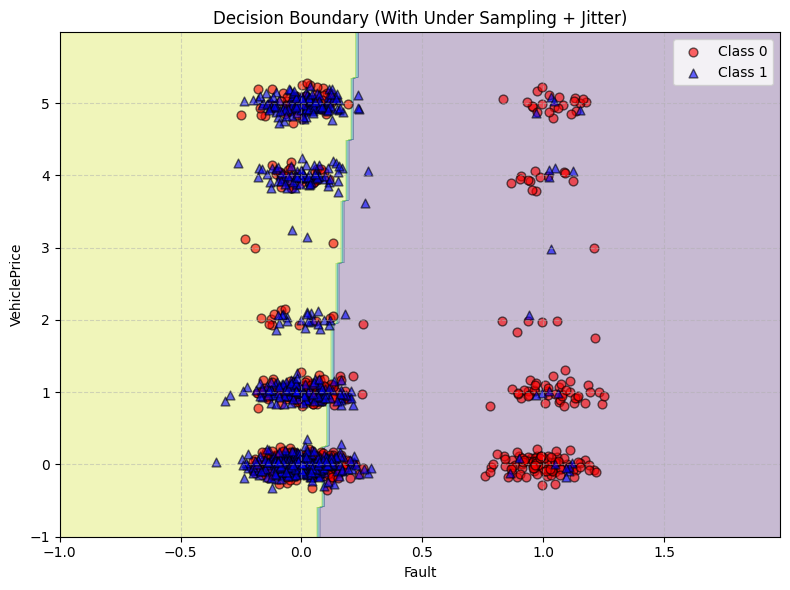

In [ ]:
from sklearn.linear_model import LogisticRegression
# Initialize and train RandomForest classifier on resampled data
classifier_rus = LogisticRegression()
classifier_rus.fit(X_resampled, y_resampled)

# Predict test set
y_pred_rus = classifier_rus.predict(X_test)
y_proba_rus = classifier_rus.predict_proba(X_test)[:, 1]

# Print classification report for resampled data
print("Classification Report (With Under Sampling):")
print(classification_report(y_test, y_pred_rus))

# Print ROC AUC Score for resampled data
print("ROC AUC Score (With Under Sampling):", roc_auc_score(y_test, y_proba_rus))

# Plotting ROC AUC Curve for resampled data
fpr_rus, tpr_rus, _ = roc_curve(y_test, y_proba_rus)
plt.figure()
plt.plot(fpr_rus, tpr_rus, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_rus))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With Under Sampling)')
plt.legend(loc="lower right")
plt.show()

def jitter(arr, noise=0.1):
    return arr + np.random.normal(0, noise, size=arr.shape)

# Function to plot decision boundaries for resampled data
def plot_decision_boundaries_ros(X, y, model, jitter_strength=0.1):
    plot_step = 0.02
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns[:2])

    for col in X.columns[2:]:
        grid_data[col] = X[col].mean()

    Z = model.predict(grid_data)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)

    # Jittered values
    x_vals = X[chi_columns[0]].values  # Use chi_columns for x_vals and y_vals
    y_vals = X[chi_columns[1]].values

    plt.scatter(jitter(x_vals[y == 0], jitter_strength),
                jitter(y_vals[y == 0], jitter_strength),
                color='red', alpha=0.6, label='Class 0', s=40, edgecolor='k', marker='o')

    plt.scatter(jitter(x_vals[y == 1], jitter_strength),
                jitter(y_vals[y == 1], jitter_strength),
                color='blue', alpha=0.6, label='Class 1', s=40, edgecolor='k', marker='^')

    plt.title("Decision Boundary (With Under Sampling + Jitter)")
    plt.xlabel(chi_columns[0])
    plt.ylabel(chi_columns[1])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot decision boundary for resampled data
plot_decision_boundaries_ros(X_resampled_df, y_resampled, classifier_rus)

### Random Oversampling

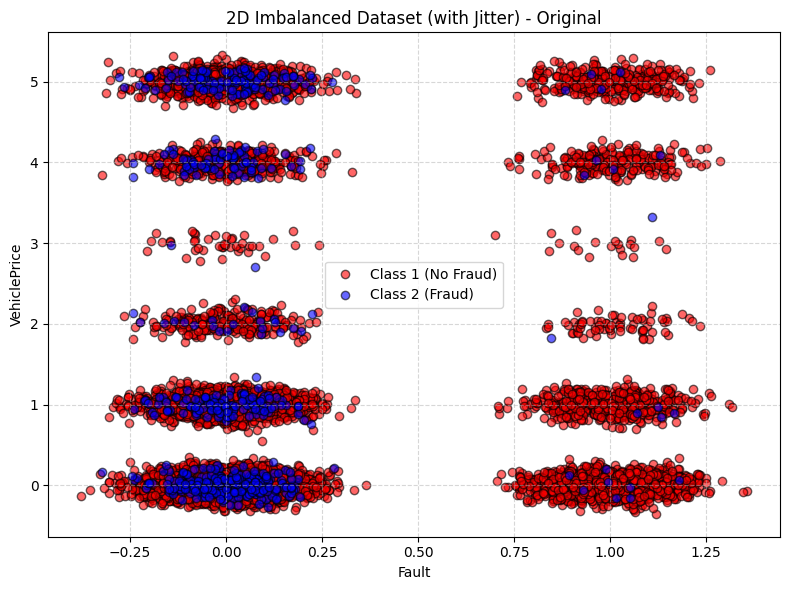

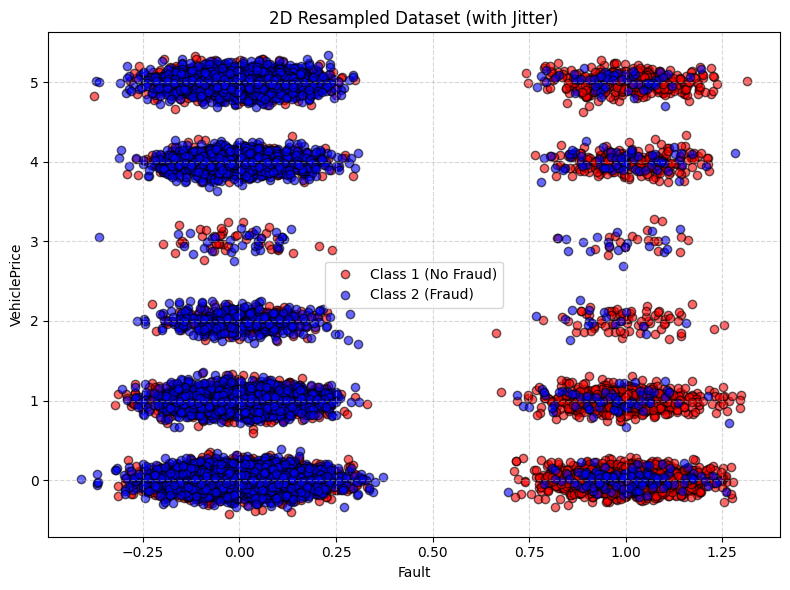

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chi, y, test_size=0.3, random_state=42)


# Applying Random Over Sampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

def jitter(arr, noise=0.1):
    return arr + np.random.normal(0, noise, size=arr.shape)


# Plotting
# Plotting (with jitter) - Original Training Set
plt.figure(figsize=(8, 6))
plt.scatter(jitter(X_train[y_train == 0].iloc[:, 0]),
            jitter(X_train[y_train == 0].iloc[:, 1]),
            color='red', label='Class 1 (No Fraud)', alpha=0.6, edgecolor='k')

plt.scatter(jitter(X_train[y_train == 1].iloc[:, 0]),
            jitter(X_train[y_train == 1].iloc[:, 1]),
            color='blue', label='Class 2 (Fraud)', alpha=0.6, edgecolor='k')

plt.title('2D Imbalanced Dataset (with Jitter) - Original')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plotting (with jitter) - Resampled Dataset
plt.figure(figsize=(8, 6))
plt.scatter(jitter(X_resampled[y_resampled == 0].iloc[:, 0]), jitter(X_resampled[y_resampled == 0].iloc[:, 1]), color='red', label='Class 1 (No Fraud)', alpha=0.6, edgecolor='k')
plt.scatter(jitter(X_resampled[y_resampled == 1].iloc[:, 0]), jitter(X_resampled[y_resampled == 1].iloc[:, 1]), color='blue', label='Class 2 (Fraud)', alpha=0.6, edgecolor='k')
plt.title('2D Resampled Dataset (with Jitter)')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
X_train.shape

(10794, 3)

In [ ]:
X_resampled.shape

(20312, 3)

In [ ]:
pd.Series(y_train).value_counts()

,count
fraud_encoded,
0,10156
1,638


In [ ]:
pd.Series(y_resampled).value_counts()

,count
fraud_encoded,
0,10156
1,10156


Classification Report (With Over Sampling):
              precision    recall  f1-score   support

           0       0.99      0.58      0.74      4341
           1       0.13      0.92      0.22       285

    accuracy                           0.61      4626
   macro avg       0.56      0.75      0.48      4626
weighted avg       0.94      0.61      0.70      4626

ROC AUC Score (With Over Sampling): 0.7790023319067075


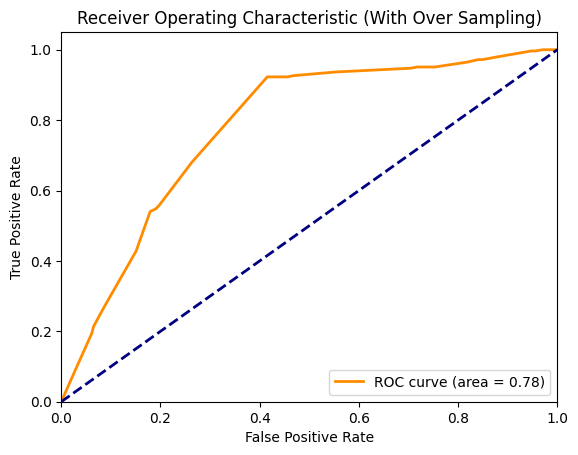

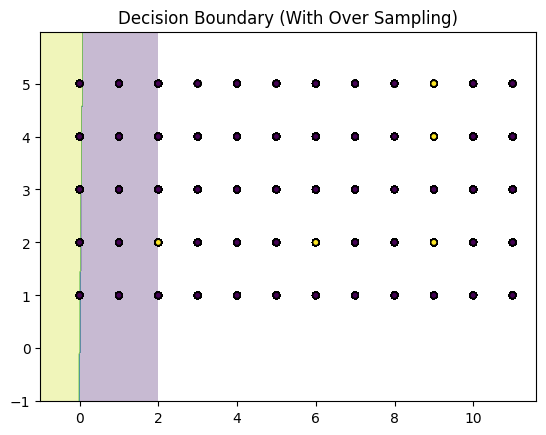

In [ ]:
# Initialize and train RandomForest classifier on resampled data
classifier_ros = LogisticRegression()
classifier_ros.fit(X_resampled, y_resampled)

# Predict test set
y_pred_ros = classifier_ros.predict(X_test)
y_proba_ros = classifier_ros.predict_proba(X_test)[:, 1]

# Print classification report for resampled data
print("Classification Report (With Over Sampling):")
print(classification_report(y_test, y_pred_ros))

# Print ROC AUC Score for resampled data
print("ROC AUC Score (With Over Sampling):", roc_auc_score(y_test, y_proba_ros))

# Plotting ROC AUC Curve for resampled data
fpr_ros, tpr_ros, _ = roc_curve(y_test, y_proba_ros)
plt.figure()
plt.plot(fpr_ros, tpr_ros, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_ros))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With Over Sampling)')
plt.legend(loc="lower right")
plt.show()

def plot_decision_boundaries_ros(X, y, model):
    plot_step = 0.02
    # Accessing the first two columns of the DataFrame using .iloc
    x_min, x_max = X_chi.iloc[:, 0].min() - 1, X_chi.iloc[:, 0].max() + 1
    y_min, y_max = X_chi.iloc[:, 1].min() - 1, X_chi.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # Create a DataFrame with the same columns as the original data
    # but using the meshgrid values for the first two features
    grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_chi.columns[:2])

    # Fill the remaining columns with the mean values from the original data
    for col in X_chi.columns[2:]:
        grid_data[col] = X_chi[col].mean()

    Z = model.predict(grid_data)  # Predict using the full feature set
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    # Accessing the first two columns of the DataFrame for scattering using .iloc
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', s=20)
    plt.title("Decision Boundary (With Over Sampling)")
    plt.show()

# Plot decision boundary for resampled data
plot_decision_boundaries_ros(X, y, classifier_ros)


### SMOTE

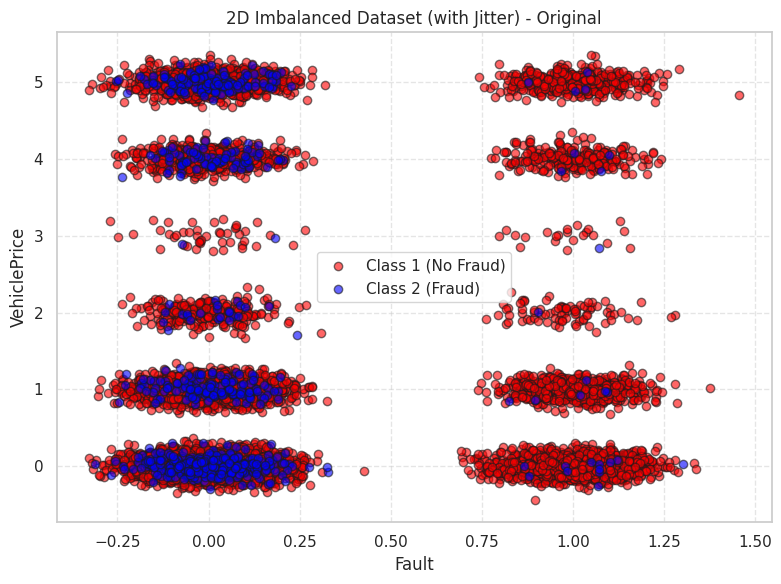

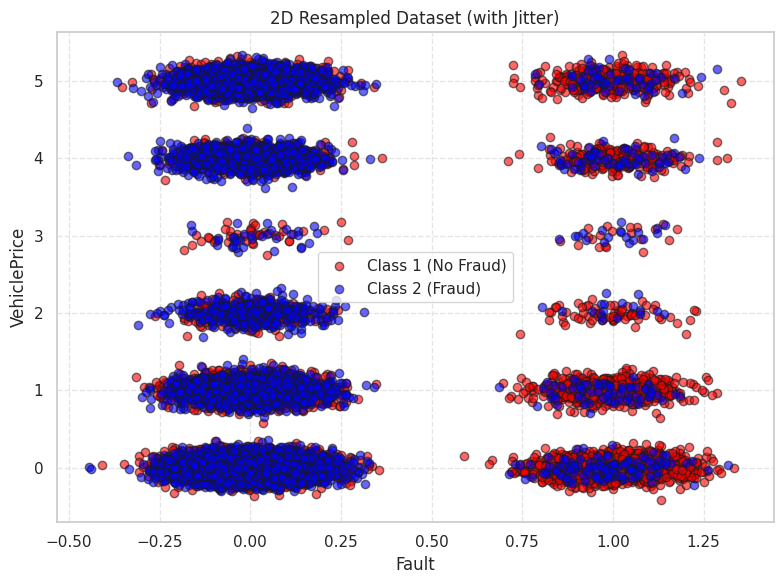

In [ ]:
from imblearn.over_sampling import SMOTE

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chi, y, test_size=0.2, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)


# Plotting (with jitter) - Original Training Set
plt.figure(figsize=(8, 6))
plt.scatter(jitter(X_train[y_train == 0].iloc[:, 0]),
            jitter(X_train[y_train == 0].iloc[:, 1]),
            color='red', label='Class 1 (No Fraud)', alpha=0.6, edgecolor='k')

plt.scatter(jitter(X_train[y_train == 1].iloc[:, 0]),
            jitter(X_train[y_train == 1].iloc[:, 1]),
            color='blue', label='Class 2 (Fraud)', alpha=0.6, edgecolor='k')

plt.title('2D Imbalanced Dataset (with Jitter) - Original')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plotting (with jitter) - Resampled Dataset
plt.figure(figsize=(8, 6))
plt.scatter(jitter(X_resampled[y_resampled == 0].iloc[:, 0]),
            jitter(X_resampled[y_resampled == 0].iloc[:, 1]),
            color='red', label='Class 1 (No Fraud)', alpha=0.6, edgecolor='k')

plt.scatter(jitter(X_resampled[y_resampled == 1].iloc[:, 0]),
            jitter(X_resampled[y_resampled == 1].iloc[:, 1]),
            color='blue', label='Class 2 (Fraud)', alpha=0.6, edgecolor='k')

plt.title('2D Resampled Dataset (with Jitter)')
plt.xlabel(chi_columns[0])
plt.ylabel(chi_columns[1])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
X_train.shape

(12336, 3)

In [ ]:
X_resampled_smote.shape

(23220, 3)

In [ ]:
pd.Series(y_train).value_counts()

,count
fraud_encoded,
0,11610
1,726


In [ ]:
pd.Series(y_resampled_smote).value_counts()

,count
fraud_encoded,
0,11610
1,11610


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_chi, y, test_size=0.2, random_state=42)

# Step 2: Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# Step 3: Train classifier on resampled data
classifier_smote = LogisticRegression()
classifier_smote.fit(X_resampled_smote, y_resampled_smote)

# Step 4: Predict on original test data
y_pred_smote = classifier_smote.predict(X_test)
y_proba_smote = classifier_smote.predict_proba(X_test)[:, 1]

# Step 5: Print evaluation metrics
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_smote))

print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_smote))


Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2887
           1       0.13      0.93      0.23       197

    accuracy                           0.60      3084
   macro avg       0.56      0.76      0.48      3084
weighted avg       0.94      0.60      0.70      3084

ROC AUC Score (With SMOTE): 0.7874314931805275


Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2887
           1       0.13      0.93      0.23       197

    accuracy                           0.60      3084
   macro avg       0.56      0.76      0.48      3084
weighted avg       0.94      0.60      0.70      3084

ROC AUC Score (With SMOTE): 0.7874314931805275


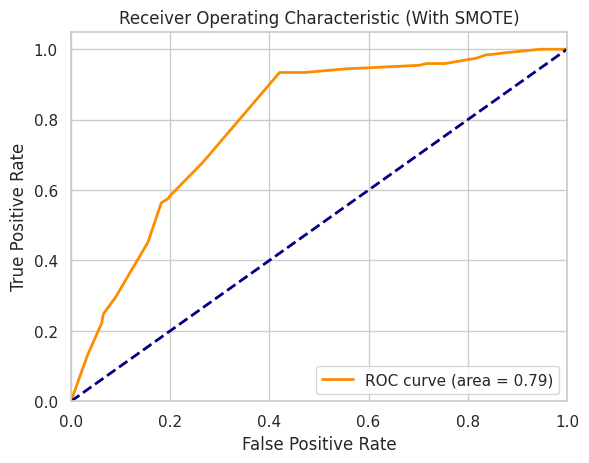

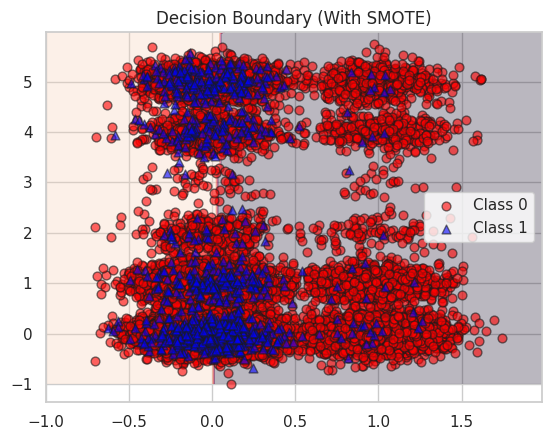

In [ ]:
# Initialize and train RandomForest classifier on resampled data
classifier_smote = LogisticRegression()
classifier_smote.fit(X_resampled_smote, y_resampled_smote)

# Predict test set
y_pred_smote = classifier_smote.predict(X_test)
y_proba_smote = classifier_smote.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_smote))

# Print ROC AUC Score for SMOTE data
print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_smote))

# Plotting ROC AUC Curve for SMOTE data
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
plt.figure()
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_smote))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With SMOTE)')
plt.legend(loc="lower right")
plt.show()

def plot_decision_boundaries_smote(X, y, model, jitter_strength=0.1):
    plot_step = 0.02
    x_min, x_max = X_chi.iloc[:, 0].min() - 1, X_chi.iloc[:, 0].max() + 1
    y_min, y_max = X_chi.iloc[:, 1].min() - 1, X_chi.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_resampled_smote.columns[:2])

    for col in X_chi.columns[2:]:
        grid_data[col] = X_chi[col].mean()

    Z = model.predict(grid_data)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)

    # --- Jitter added here ---
    x_vals = X_chi.iloc[:, 0].values
    y_vals = X_chi.iloc[:, 1].values

    # Apply jitter to x and y values:
    x_jittered = x_vals + np.random.normal(0, jitter_strength, size=len(x_vals))
    y_jittered = y_vals + np.random.normal(0, jitter_strength, size=len(y_vals))

    # --- Scatter plot with red and blue colors ---
    plt.scatter(x_jittered[y == 0], y_jittered[y == 0],
                color='red', alpha=0.6, label='Class 0',
                s=40, edgecolor='k', marker='o')  # Red for class 0

    plt.scatter(x_jittered[y == 1], y_jittered[y == 1],
                color='blue', alpha=0.6, label='Class 1',
                s=40, edgecolor='k', marker='^')  # Blue for class 1
    # --- End of scatter plot ---

    plt.title("Decision Boundary (With SMOTE)")
    plt.legend()  # Add a legend to show the color mapping
    plt.show()

# When calling the function, you can adjust the jitter strength:
plot_decision_boundaries_smote(X, y, classifier_smote, jitter_strength=0.2)

### Balanced Random Forest

Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2887
           1       0.13      0.93      0.23       197

    accuracy                           0.60      3084
   macro avg       0.56      0.76      0.48      3084
weighted avg       0.94      0.60      0.70      3084

ROC AUC Score (With SMOTE): 0.7871730266431527


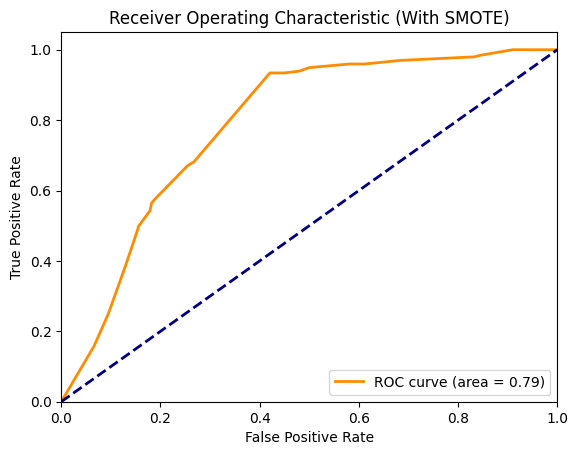

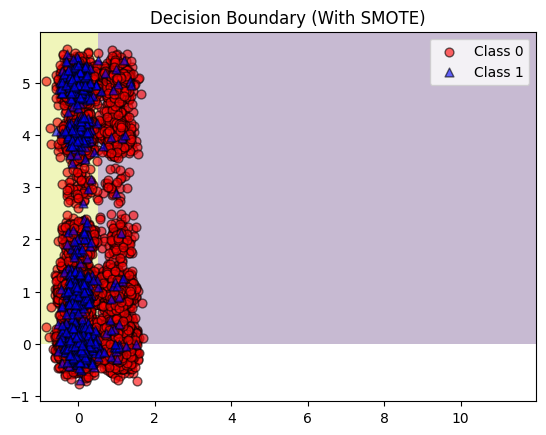

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chi, y, test_size=0.2, random_state=42)

# Applying SMOTE
classifier = BalancedRandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict test set
y_pred_brf = classifier.predict(X_test)
y_proba_brf = classifier.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_brf))

# Print ROC AUC Score for SMOTE data
print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_brf))

# Plotting ROC AUC Curve for SMOTE data
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_proba_brf)
plt.figure()
plt.plot(fpr_brf, tpr_brf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_brf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With SMOTE)')
plt.legend(loc="lower right")
plt.show()

from imblearn.ensemble import BalancedRandomForestClassifier

#  Function to plot decision boundaries for SMOTE data
def plot_decision_boundaries_smote(X, y, model, jitter_strength=0.1):
    plot_step = 0.02
    # Access the first two features for plotting:
    X_plot = X.iloc[:, :2].values
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # Use the correct column names from X_chi when creating grid_data
    grid_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_chi.columns[:2])
    for col in X_chi.columns[2:]:
        grid_data[col] = X_chi[col].mean()

    Z = model.predict(grid_data)  # Predict using the full feature set
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)

    # --- Jitter and Red/Blue Colors ---
    x_vals = X[X_chi.columns[0]].values  # Get x values using the correct column name
    y_vals = X[X_chi.columns[1]].values  # Get y values using the correct column name

    # Apply jitter
    x_jittered = x_vals + np.random.normal(0, jitter_strength, size=len(x_vals))
    y_jittered = y_vals + np.random.normal(0, jitter_strength, size=len(y_vals))

    # Scatter plot with red and blue colors
    plt.scatter(x_jittered[y == 0], y_jittered[y == 0],
                color='red', alpha=0.6, label='Class 0',
                s=40, edgecolor='k', marker='o')  # Red for class 0

    plt.scatter(x_jittered[y == 1], y_jittered[y == 1],
                color='blue', alpha=0.6, label='Class 1',
                s=40, edgecolor='k', marker='^')  # Blue for class 1
    # --- End of Jitter and Colors ---

    plt.title("Decision Boundary (With SMOTE)")
    plt.legend()
    plt.show()

# Plot decision boundary for SMOTE data
plot_decision_boundaries_smote(X, y, classifier, jitter_strength=0.2)

# Logistic regression

Logistic regression using softmax

In [ ]:
# Import StandardScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Softmax Regression from Scratch
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot(self, y, num_classes):
        one_hot_y = np.zeros((y.size, num_classes))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.num_classes = np.max(y) + 1
        self.W = np.zeros((n_features, self.num_classes))
        self.b = np.zeros((1, self.num_classes))
        y_one_hot = self.one_hot(y, self.num_classes)

        for epoch in range(self.epochs):
            logits = np.dot(X, self.W) + self.b
            probs = self.softmax(logits)

            error = probs - y_one_hot
            dW = np.dot(X.T, error) / n_samples
            db = np.sum(error, axis=0, keepdims=True) / n_samples

            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db

    def predict(self, X):
        logits = np.dot(X, self.W) + self.b
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Step 7: Train and Evaluate
model = SoftmaxRegression(learning_rate=0.1, epochs=1000)
model.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score

# If binary, you need the probability of class 1
probs = model.softmax(np.dot(X_test, model.W) + model.b)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")


print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}")


[[2887    0]
 [ 197    0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       0.00      0.00      0.00       197

    accuracy                           0.94      3084
   macro avg       0.47      0.50      0.48      3084
weighted avg       0.88      0.94      0.91      3084

ROC-AUC Score: 0.8112
Train Accuracy: 0.9411
Test Accuracy: 0.9361


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Import StandardScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_chi)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Softmax Regression from Scratch
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot(self, y, num_classes):
        one_hot_y = np.zeros((y.size, num_classes))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.num_classes = np.max(y) + 1
        self.W = np.zeros((n_features, self.num_classes))
        self.b = np.zeros((1, self.num_classes))
        y_one_hot = self.one_hot(y, self.num_classes)

        for epoch in range(self.epochs):
            logits = np.dot(X, self.W) + self.b
            probs = self.softmax(logits)

            error = probs - y_one_hot
            dW = np.dot(X.T, error) / n_samples
            db = np.sum(error, axis=0, keepdims=True) / n_samples

            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db

    def predict(self, X):
        logits = np.dot(X, self.W) + self.b
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Step 7: Train and Evaluate
model = SoftmaxRegression(learning_rate=0.1, epochs=1000)
model.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score

# If binary, you need the probability of class 1
probs = model.softmax(np.dot(X_test, model.W) + model.b)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")


print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}")


[[2887    0]
 [ 197    0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       0.00      0.00      0.00       197

    accuracy                           0.94      3084
   macro avg       0.47      0.50      0.48      3084
weighted avg       0.88      0.94      0.91      3084

ROC-AUC Score: 0.7874
Train Accuracy: 0.9411
Test Accuracy: 0.9361


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# Initialize and train RandomForest classifier on resampled data
classifier_smote = LogisticRegression()
classifier_smote.fit(X_resampled_smote, y_resampled_smote)

# Predict test set
y_pred_smote = classifier_smote.predict(X_test)
y_proba_smote = classifier_smote.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE all data):")
print(classification_report(y_test, y_pred_smote))

# Print ROC AUC Score for SMOTE data
print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_smote))

Classification Report (With SMOTE all data):
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      2887
           1       0.10      0.42      0.16       197

    accuracy                           0.72      3084
   macro avg       0.53      0.58      0.50      3084
weighted avg       0.90      0.72      0.79      3084

ROC AUC Score (With SMOTE): 0.6602237581737844


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<ipython-input-30-abc37e9ad695>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")


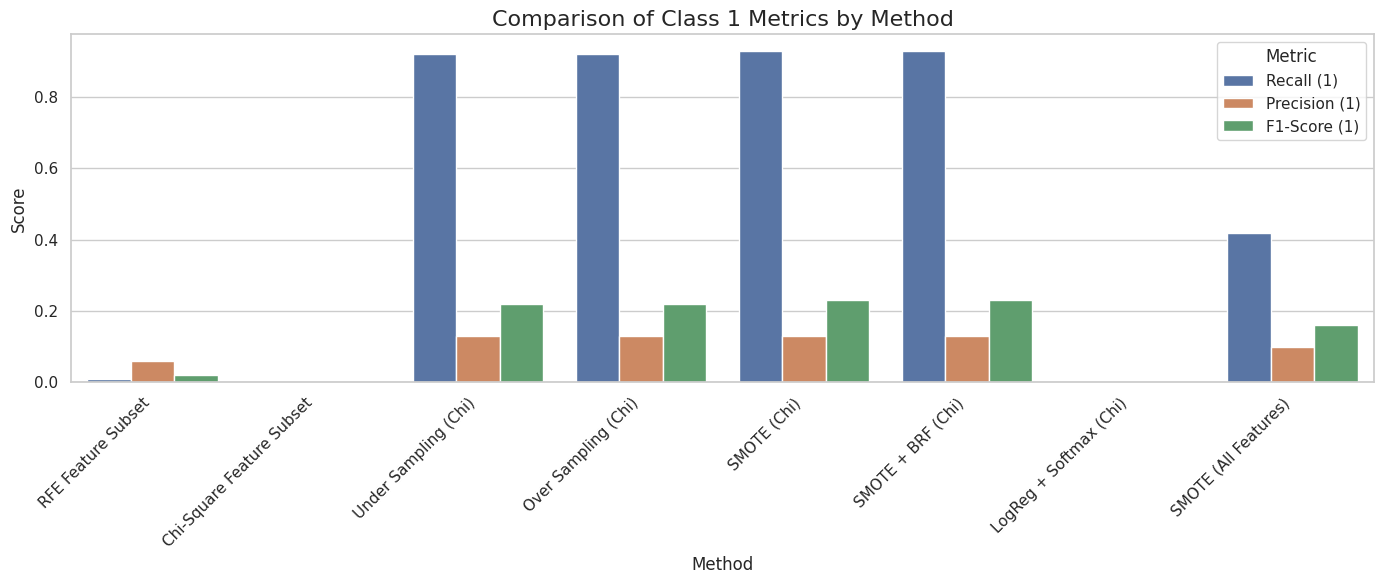

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data from the comparison table
data = {
    "Method": [
        "RFE Feature Subset", "Chi-Square Feature Subset",
        "Under Sampling (Chi)", "Over Sampling (Chi)",
        "SMOTE (Chi)", "SMOTE + BRF (Chi)",
        "LogReg + Softmax (Chi)", "SMOTE (All Features)"
    ],
    "Recall (1)": [0.01, 0.00, 0.92, 0.92, 0.93, 0.93, 0.00, 0.42],
    "Precision (1)": [0.06, 0.00, 0.13, 0.13, 0.13, 0.13, 0.00, 0.10],
    "F1-Score (1)": [0.02, 0.00, 0.22, 0.22, 0.23, 0.23, 0.00, 0.16],
    "ROC AUC": [None, None, 0.779, 0.779, 0.787, 0.787, 0.811, 0.66]
}

df = pd.DataFrame(data)

# Melt the dataframe for plotting
metrics_melted = df.melt(id_vars="Method", value_vars=["Recall (1)", "Precision (1)", "F1-Score (1)"],
                         var_name="Metric", value_name="Score")

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plot = sns.barplot(data=metrics_melted, x="Method", y="Score", hue="Metric")
plot.set_title("Comparison of Class 1 Metrics by Method", fontsize=16)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()
